In [62]:
import pandas as pd
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import IPython.display as display
from matplotlib import animation

In [63]:
class expermentDataloader(Dataset):
    def __init__(
        self,
        index_file: str, 
        data_path: str,
        startIndex = 0,
        endIndex = -1
    ):
        self.root_dir = data_path
        self.expermentSikeTrainsIndex = np.array(pd.read_csv(index_file,header=None))[startIndex:endIndex] # self.landmarks_frame = pd.read_csv(csv_file)
        # endIndex = len(self.expermentSikeTrainsIndex) if endIndex == -1 else endIndex
        self.spikeTrains = [
            f"{os.path.join(self.expermentSikeTrainsIndex[i][0])}" for i in range(len(self.expermentSikeTrainsIndex)) 
        ]
        self.targets = self.expermentSikeTrainsIndex[:, 1]

    def __getitem__(self, index):
        inputCSVlines = pd.read_csv(os.path.join(self.root_dir,self.spikeTrains[index])).to_numpy()
        targetCSVLines = self.targets[index]
        return inputCSVlines.flatten(), np.array([targetCSVLines])

    def __len__(self):
        return len(self.expermentSikeTrainsIndex)


dataPath = "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/allData"
dataPathIndex = "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/allData/index.csv"

# trainingData = expermentDataloader(dataPathIndex,dataPath, startIndex=0, endIndex=156)
trainingData = expermentDataloader(dataPathIndex,dataPath, startIndex=0, endIndex=100)
testData = expermentDataloader(dataPathIndex,dataPath, startIndex=101, endIndex=156)
# input = trainingData[0][0]
# target = trainingData[0][1]
data, target = trainingData[0]
# data, target = testData[0]

In [64]:
print(len(trainingData))
print(len(testData))

100
55


In [65]:
print(np.sum(data))
target

152


array([339])

In [66]:
len(trainingData[0][0])

8999

In [67]:
len(trainingData[1][0])

8999

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt

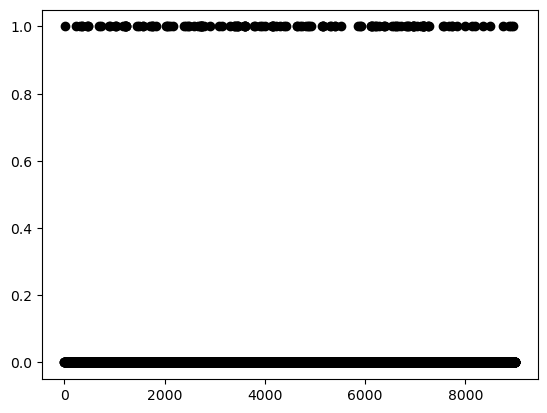

In [69]:
plt.plot(list(range(len(trainingData[0][0]))), trainingData[0][0], 'o', color='black')

In [70]:
target

array([339])

In [71]:
data

array([0, 0, 0, ..., 0, 0, 0])

In [121]:
import torch
from torch import nn

In [144]:
model = nn.Sequential(
          nn.Linear(len(data),len(data)),
          nn.ReLU(),
          nn.Linear(len(data),len(data)),
          nn.ReLU(),
          nn.Linear(len(data),1),
          nn.ReLU()
        )
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Linear(in_features=8999, out_features=8999, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8999, out_features=8999, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8999, out_features=1, bias=True)
  (5): ReLU()
)

In [145]:
MSE = nn.MSELoss()
adam = torch.optim.Adam(model.parameters(),lr=0.00001)

In [106]:
# targetPlot = torch.from_numpy(target[:,0]).float()
targetTorch = torch.tensor(target).float().to(device)
inputTorch = torch.from_numpy(data).float().to(device)

In [103]:
for _ in range(50):
    output = model(inputTorch)
    loss = MSE(output, targetTorch)
    adam.zero_grad()
    loss.backward()
    adam.step()
    outputPlot = output.clone().detach().cpu().numpy()
    print(loss,end="\r")
    

In [107]:
outputPlot

array([4.915713], dtype=float32)

In [152]:
from torch.utils.data import DataLoader
batch_size = 10
dataPath = "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/allData"
dataPathIndex = "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/allData/index.csv"
trainingData = expermentDataloader(dataPathIndex,dataPath, startIndex=0, endIndex=125)
testData = expermentDataloader(dataPathIndex,dataPath, startIndex=126, endIndex=156)
trainDataset = DataLoader(trainingData, batch_size=batch_size, shuffle=True)
testDataset = DataLoader(testData, batch_size=batch_size, shuffle=True)

In [153]:
device

device(type='cuda', index=1)

In [163]:
model = nn.Sequential(
          nn.Linear(len(data),len(data)),
          nn.ReLU(),
          nn.Linear(len(data),len(data)),
          nn.ReLU(),
          nn.Linear(len(data),1),
          nn.ReLU()
        )
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)
MSE = nn.MSELoss()
adam = torch.optim.Adam(model.parameters(),lr=0.00001)

epochs = 150
losses = []
accs = []
print("training...")
for e in range(epochs): 
    avgLoss = []
    currentAcc = []
    for i, (inputs, targets) in enumerate(trainDataset):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        loss = MSE(outputs, targets)
        adam.zero_grad()
        loss.backward()
        adam.step()
        outputPlot = outputs.clone().detach().cpu().numpy()
        targetsPlot = targets.clone().detach().cpu().numpy()
        losses.append(float(loss.clone().detach().cpu().numpy()))
        avgLoss.append(float(loss.clone().detach().cpu().numpy()))
        totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), rtol=.1))
        totalCorrect = totalCorrect.clone().detach().cpu().numpy()
        currentAcc.append(float(totalCorrect/len(targets)))
        accs.append(float(totalCorrect/len(targets)))
    print(f"\
        epoch: {e}/{epochs}\t \
        loss:{np.sum(avgLoss)/len(avgLoss)}\t \
        accuracy:{np.sum(currentAcc)/len(currentAcc)} \
        ",end="\x1b\r")
    

training...


In [164]:
epochs = 100
accs = []
print("test...")
for e in range(epochs): 
    avgLoss = []
    currentAcc = []
    for i, (inputs, targets) in enumerate(testDataset):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        outputPlot = outputs.clone().detach().cpu().numpy()
        targetsPlot = targets.clone().detach().cpu().numpy()
        totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), rtol=.1))
        totalCorrect = totalCorrect.clone().detach().cpu().numpy()
        currentAcc.append(float(totalCorrect/len(targets)))
        accs.append(float(totalCorrect/len(targets)))
    print(f"\
        epoch: {e}/{epochs}\t \
        accuracy:{np.sum(currentAcc)/len(currentAcc)} \
        ",end="\x1b\r")

test...


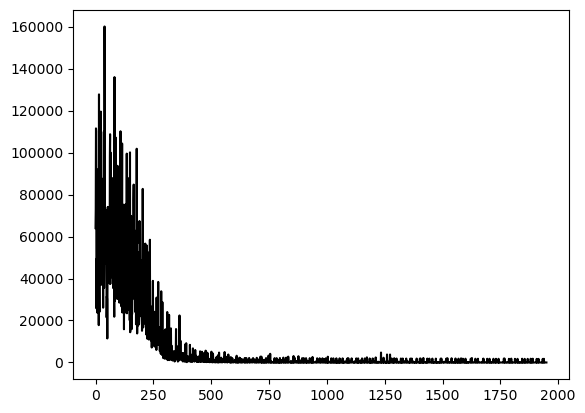

In [165]:
plt.plot(list(range(len(losses))), losses, '-', color='black')

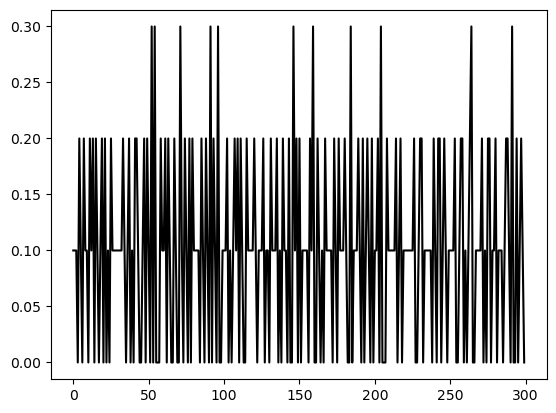

In [166]:
plt.plot(list(range(len(accs))), accs, '-', color='black')

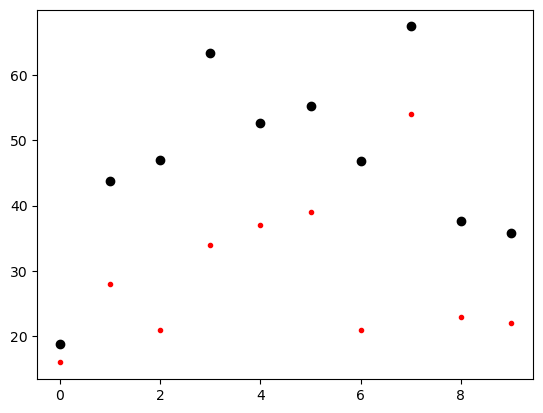

In [167]:
plt.plot(list(range(len(outputPlot))), outputPlot, 'o', color='black')
plt.plot(list(range(len(targetsPlot))), targetsPlot, '.', color='red')